##Required Installations

In [1]:
!pip install transformers --quiet
!pip install tensorflow-text --quiet
!pip install pytorch_transformers --quiet
!pip3 install sentencepiece --quiet


##Importing Dataset

In [3]:
import pandas as pd

TRAIN_DATASET_PATH = "/content/train.csv" #Please provide the directory path where the training dataset is located
TEST_DATASET_PATH = "/content/test.csv" #Please provide the directory path where the test dataset is located
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

##Train and test data cleaning

In [4]:
test_df = test_df.dropna() # Dropping empty rows in  the Dataset
train_df = train_df.dropna()
train_text = train_df['news']
train_labels = train_df['label']
test_text = test_df['news']
test_labels = test_df['label']

##Importing Model

In [5]:
from transformers import AutoModel

def get_bert_embed_matrix():
    bert = AutoModel.from_pretrained('ai4bharat/indic-bert')
    bert_embeddings = list(bert.children())[0] # Extracting the model weights
    bert_word_embeddings = list(bert_embeddings.children())[0] # Extracting all the pretrained word embeddings
    mat = bert_word_embeddings.weight.data.numpy()
    return mat

embedding_matrix = get_bert_embed_matrix()

Some weights of the model checkpoint at ai4bharat/indic-bert were not used when initializing AlbertModel: ['predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.bias', 'predictions.decoder.bias', 'predictions.dense.bias', 'sop_classifier.classifier.bias', 'predictions.LayerNorm.weight', 'predictions.decoder.weight', 'sop_classifier.classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


##Building the model

In [6]:
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D,Bidirectional

# Using Functional API to build model
inp = Input(shape = (128, ))
x = Embedding(input_dim = embedding_matrix.shape[0], output_dim  = embedding_matrix.shape[1], weights = [embedding_matrix], trainable = False)(inp)
x = Bidirectional(LSTM(120, return_sequences = True, name = 'lstm_layer', dropout = 0.1, recurrent_dropout = 0.1))(x)
# x = Bidirectional(LSTM(60, return_sequences = True, name = 'lstm_layer', dropout = 0.1, recurrent_dropout = 0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation = "relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation = "sigmoid")(x)

##Importing Tokeniser and padding of tokenised data

In [25]:
# HyperParameters to train the model
maxlen = 128
batch_size = 32
epochs = 15

In [9]:
from keras.preprocessing.text import Tokenizer

max_features = 500000 # Determines the number of tokens ie number of unique
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_text))
list_tokenized_train = tokenizer.texts_to_sequences(train_text)
list_tokenized_test = tokenizer.texts_to_sequences(test_text)

In [15]:
from keras.utils import pad_sequences

X_train = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_test = pad_sequences(list_tokenized_test, maxlen=maxlen)
y = train_labels

##Model Compilation

In [12]:
from keras.models import Model

model = Model(inputs = inp, outputs = x) # Determines the feature size of the input and output
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 embedding (Embedding)       (None, 128, 128)          25600000  
                                                                 
 bidirectional (Bidirectiona  (None, 128, 240)         239040    
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 240)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 240)               0         
                                                                 
 dense (Dense)               (None, 50)                12050 

##Traning the Dataset

In [16]:
hist = model.fit(X_train, y, batch_size = batch_size, epochs = epochs, validation_split = 0.1)

Epoch 1/20
65/65 [==============================] - 59s 904ms/step - loss: 0.5724 - accuracy: 0.7182 - val_loss: 0.5517 - val_accuracy: 0.7217
Epoch 2/20
65/65 [==============================] - 54s 839ms/step - loss: 0.5371 - accuracy: 0.7337 - val_loss: 0.5327 - val_accuracy: 0.7478
Epoch 3/20
65/65 [==============================] - 81s 1s/step - loss: 0.5088 - accuracy: 0.7637 - val_loss: 0.5094 - val_accuracy: 0.7565
Epoch 4/20
65/65 [==============================] - 81s 1s/step - loss: 0.4890 - accuracy: 0.7704 - val_loss: 0.5257 - val_accuracy: 0.7565
Epoch 5/20
65/65 [==============================] - 60s 920ms/step - loss: 0.4693 - accuracy: 0.7786 - val_loss: 0.5157 - val_accuracy: 0.7391
Epoch 6/20
65/65 [==============================] - 52s 794ms/step - loss: 0.4343 - accuracy: 0.7864 - val_loss: 0.4782 - val_accuracy: 0.7522
Epoch 7/20
65/65 [==============================] - 52s 786ms/step - loss: 0.4028 - accuracy: 0.8134 - val_loss: 0.4491 - val_accuracy: 0.7870
Epoch

##Loss Graph

<Figure size 640x480 with 0 Axes>

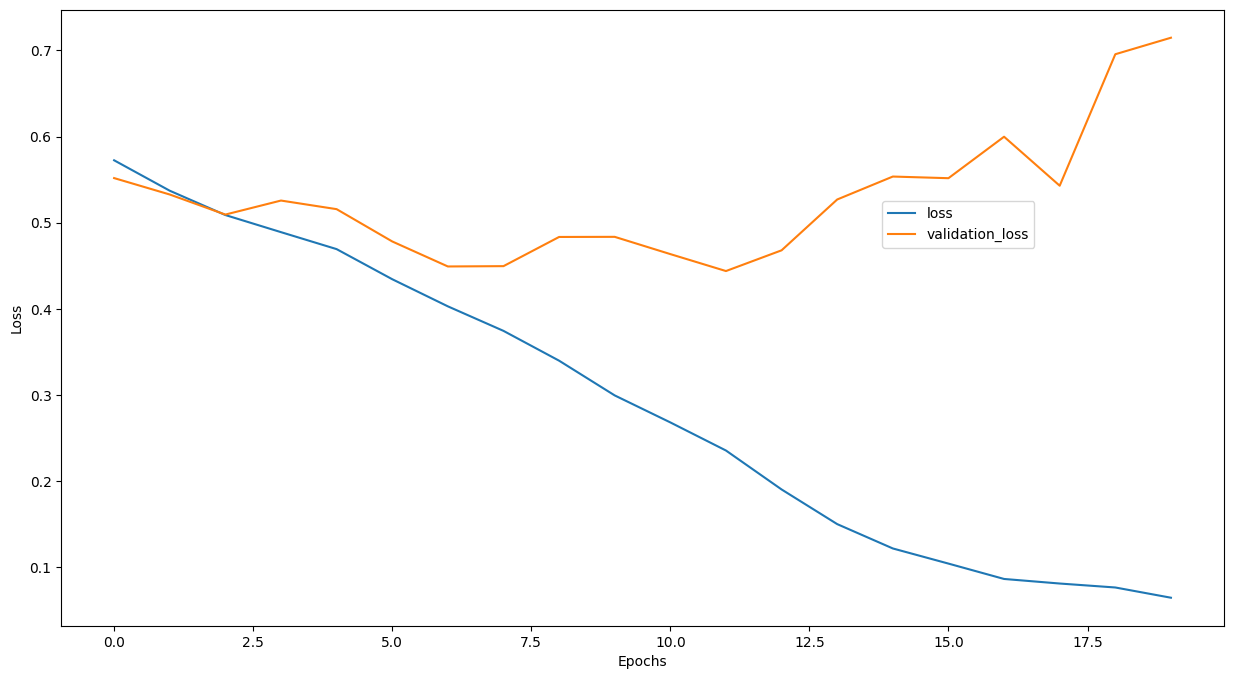

In [18]:
import matplotlib.pyplot as plt

plt.tight_layout()
plt.figure(figsize=(15,8))
plt.plot(hist.history['loss'], label = 'loss')
plt.plot(hist.history['val_loss'], label = 'validation_loss')
plt.legend(bbox_to_anchor=(0.7, 0.7))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

##Graph for accuracy

<Figure size 640x480 with 0 Axes>

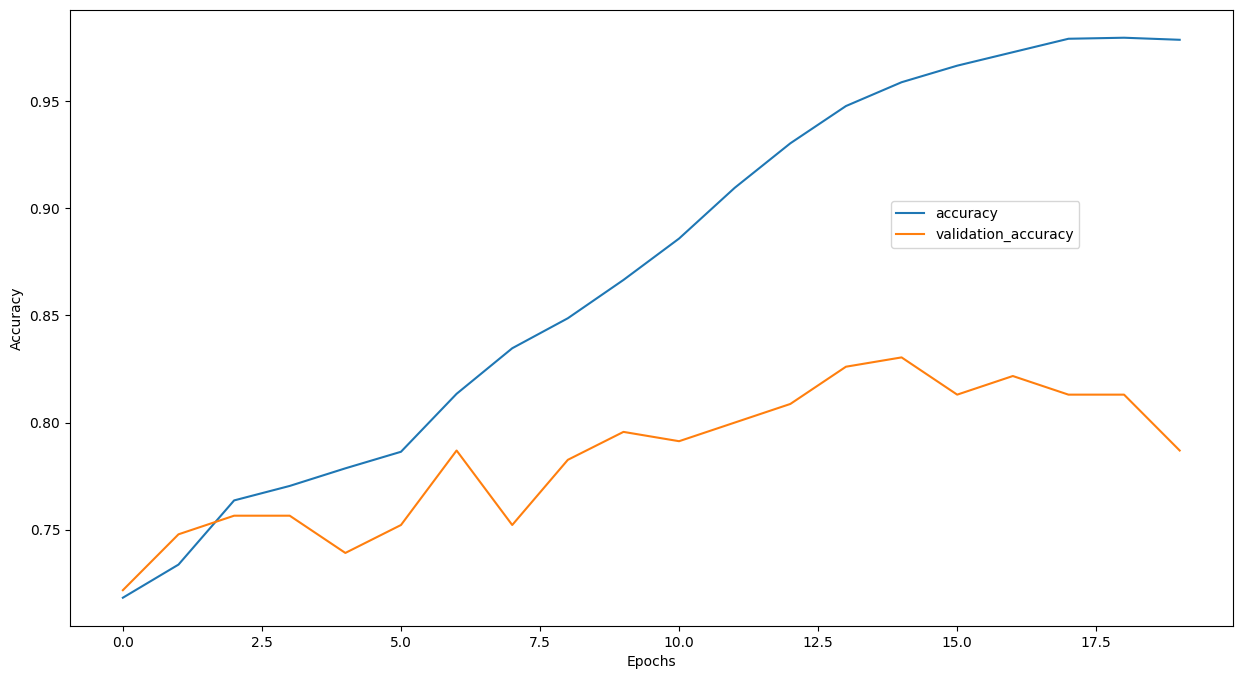

In [19]:
plt.tight_layout()
plt.figure(figsize=(15,8))
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label='validation_accuracy')
plt.legend(bbox_to_anchor=(0.7, 0.7))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

##Obtaining predictions formatting predictions

In [20]:
y_test = list(test_labels)

In [21]:
import numpy as np

y_pred=model.predict(X_test)
Y_pred = np.array(y_pred.round())
Y_pred = list(map(lambda x : int(x),Y_pred)) # Used to convert the values into integers

16/16 [==============================] - 3s 166ms/step


##Classification report

In [22]:
from sklearn.metrics import classification_report

print(classification_report(y_test,Y_pred))

              precision    recall  f1-score   support

           0       0.65      0.73      0.69       200
           1       0.81      0.74      0.77       300

    accuracy                           0.74       500
   macro avg       0.73      0.74      0.73       500
weighted avg       0.74      0.74      0.74       500



##Confusion matrix

In [23]:
from sklearn.metrics import confusion_matrix

cm=confusion_matrix(y_test, Y_pred)

<Axes: >

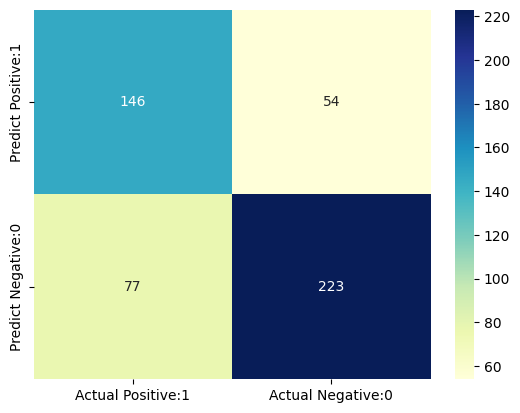

In [24]:
#Visualizing the confusion matrix
import seaborn as sns

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], index=['Predict Positive:1', 'Predict Negative:0'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')